This notebook will be a little different than the others. Behind the scene we did some extra work: we retrieved from Onboard API wrapper all the fan coil units (FCU) time-series from october 2017 to october 2018. You can find them in the principal page of this data-set, under the "data" tab. Each point (sensor) was renamed with the structure: *buildingID_equipmentID_pointID*. These are the columns of the data set.

We will be selecting some of them in order to show some simple use cases for these time-series!

In [1]:
# install API wrapper first
#!pip install onboard.client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 KB 1.1 MB/s eta 0:00:00
  Attempting uninstall: orjson
    Found existing installation: orjson 3.6.7
    Uninstalling orjson-3.6.7:
      Successfully uninstalled orjson-3.6.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.37.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.4 which is incompatible.
apache-beam 2.37.0 requires httplib2<0.20.0,>=0.8, but you have httplib2 0.20.4 which is incompatible.
apache-beam 2.37.0 requires pyarrow<7.0.0,>=0.15.1, but you have pyarrow 7.0.0 which is incompatible.


In [11]:
import pandas as pd
from onboard.client import RtemClient

import matplotlib.pyplot as plt
import seaborn as sns

# This is for the visual style, I like "ggplot"
plt.style.use('ggplot')

# This for the figure size
plt.rcParams["figure.figsize"] = (36,18)

In [12]:
api_key = 'ob-p-_KnPccpVFOwKvS5u_SpKixHjKKq6H1JvrzwjxISOfPiNKKZ56_EeE5ORVJOGGtx0d_k'

In [13]:
# # You can ignore this part, is for keeping my API key secret
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# api_key = user_secrets.get_secret("hackaton_key")

In [14]:
client = RtemClient(api_key=api_key)

# Detecting atypical behaviour

First step is to load the data set we will be exploring. We are going to work with the discharge air temperature sensors readings from the FCU. These sensors are used to measure the temperature of the air that is emitted from the air ducts; if the temperature here is not right, something may be going wrong (the sensor or the FCU). In general, nobody cares about the FCU working wrong unless someone says something about being uncomfortable with the zone temperature. Let's try to visually detect the units that are not working correctly from the data we have.

Also, we have the command time-series. These are time-series that which only values are 0 or 1, indicating if the unit should be on or off. Let's import it too and use it later.

## Load & processing

Here are the raw reading, let's import them. Remember to use the paramete `parse_dates` to load the timestamo column as a datetime object.

In [15]:
df_temp_raw = pd.read_csv("rtem_boiler_hhws_time_series.csv", parse_dates=["timestamp"])
df_cmd_raw = pd.read_csv("./fcu/fcu_command_20171001_20181001.csv", parse_dates=["timestamp"])

Aswe explained above, the columns here are renamed with the structure *buildingID_equipmentID_pointID*; let's sort the columns of our data set in order to have all the sensors from the same building together.

In [16]:
# Sort columns by bdg
sorted_cols = ["timestamp"] + sorted(df_temp_raw.columns[1:])
df_temp = df_temp_raw[sorted_cols]

Check the 111 points we have here, these are the new names:

In [17]:
df_temp.columns

Index(['timestamp', '194188', '194193', '197306', '197308', '199523', '199546',
       '201534', '204548', '204552', '209222', '209234', '209246', '209258',
       '222746'],
      dtype='object')

Let's resample the data hourly. We are working with temperature readings, we will aggregate by the mean. So we will have a data set with the hourly mean discharge air temperature.

In [18]:
df_temp = df_temp.resample("1H", on="timestamp").mean()

## Visual exploration

First of all, let's create a heatmap with our data set. We have hourly readings per point, let's transpose our dataframe in order to have the points' ids on the Y axis and the timestamp on the X.

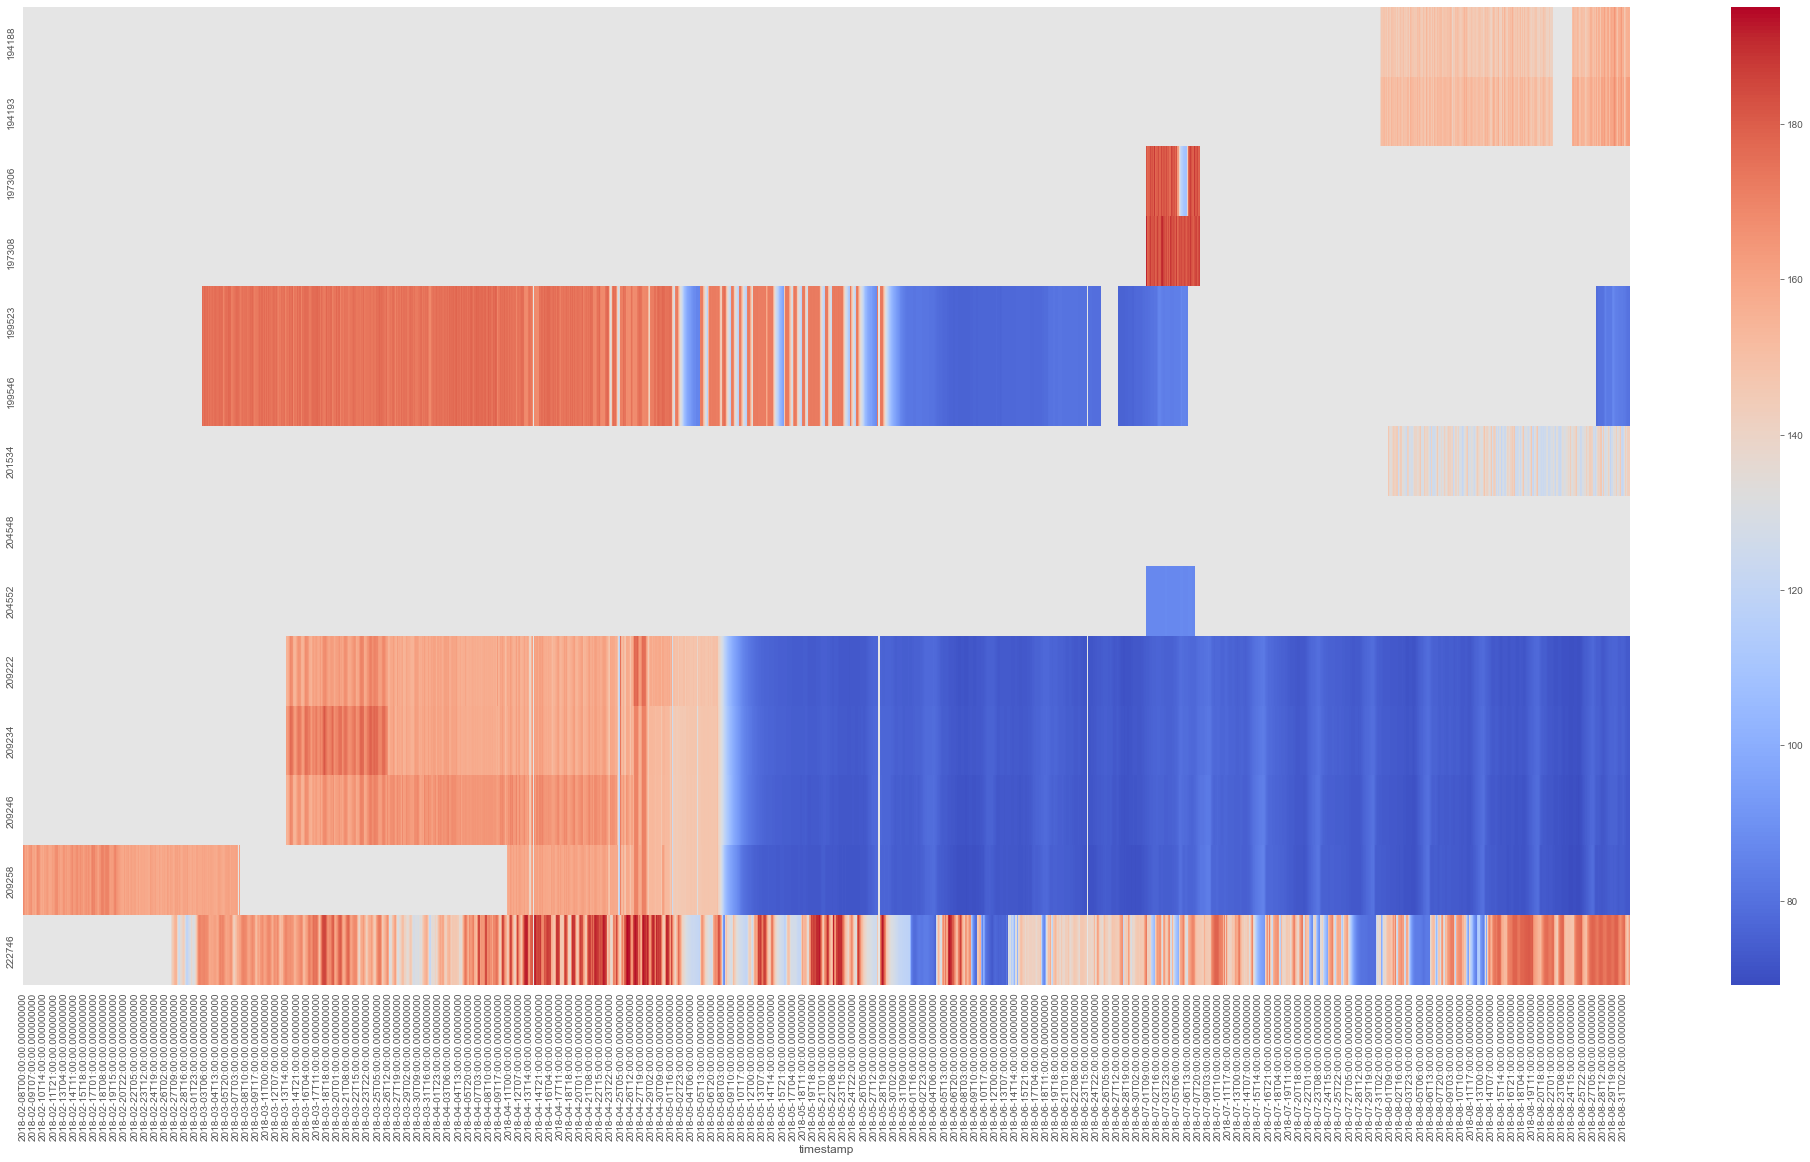

In [19]:
fig1 = sns.heatmap(df_temp.T, cmap="coolwarm")

Ok, first thing pretty evident is that in building 354 there are a couple of sensors with really high temperatures in comparison to the other points for the same period. Let's start by focusing on them. We will select them and create a new dataframe:

In [20]:
# First select the columns that have "354" in it
cols354 = df_temp.columns[df_temp.columns.str.contains("222746")]

# Then, select the columns from the dataframe
bdg354 = df_temp[cols354]

Before inspect them visually, let's learn about the building getting that information from Onboar API:

In [22]:
bdgs = pd.DataFrame(client.get_all_buildings())
bdgs[bdgs.id == 222746]

,id,org_id,name,address,sq_ft,image_src,bms_manufacturer,bms_product_name,bms_version,timezone,info,status,equip_count,point_count


Ok, a New York building. During those weird behaviour months is winter; could make sense if all the point had the same behaviour, but that's not the case. And a winter that cold? to need 160ºF? Definitely somthing happening here.

Let's plot the heatmap again, but this time focusing only on this building.

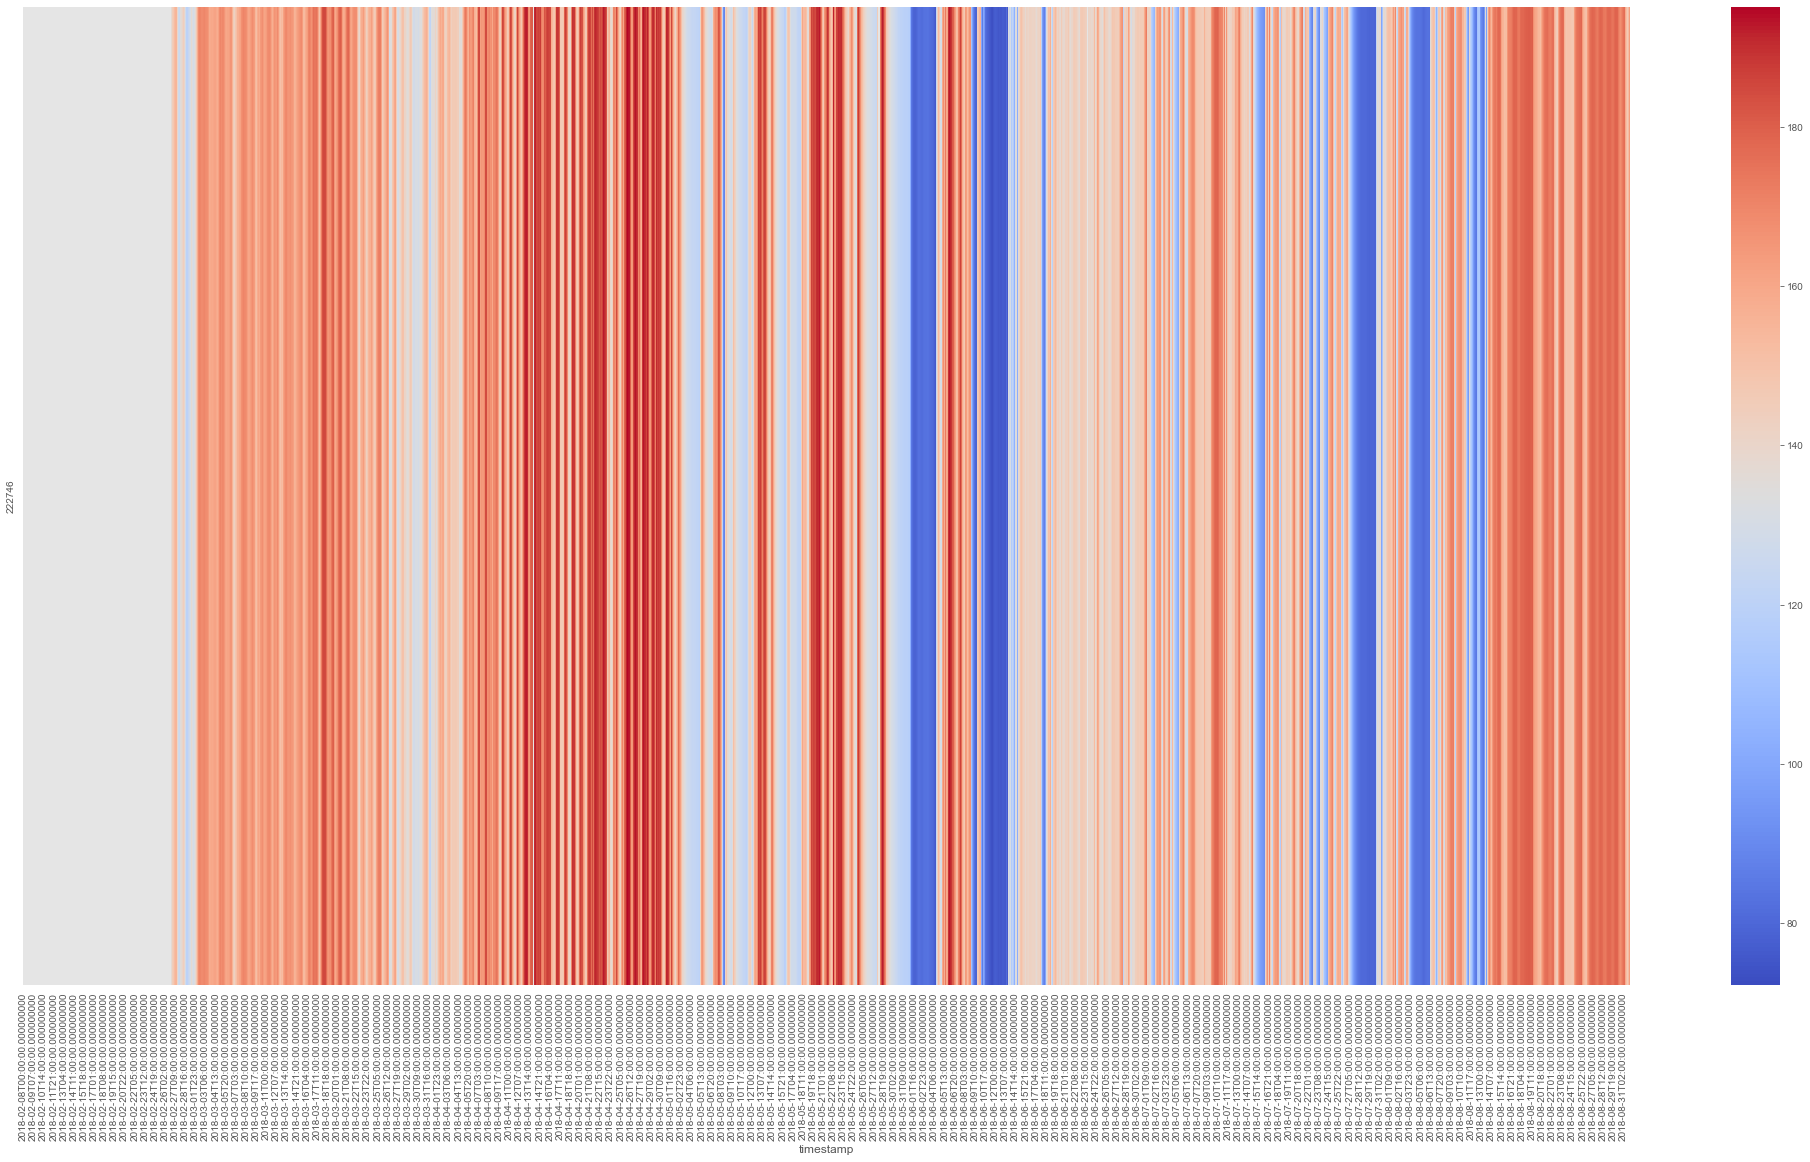

In [23]:
fig2 = sns.heatmap(bdg354.T, cmap="coolwarm")

There are three points there with a weird behaviour at the beginning of the time period, we will select them:

In [20]:
points = ["354_21649_222929", "354_21668_223059", "354_21678_223187"]

And filter the dataset to have only those three columns:

In [21]:
sel_points = df_temp[points].reset_index()
sel_points

,timestamp,354_21649_222929,354_21668_223059,354_21678_223187
0,2017-10-01 00:00:00+00:00,NaN,NaN,NaN
1,2017-10-01 01:00:00+00:00,NaN,NaN,NaN
2,2017-10-01 02:00:00+00:00,NaN,NaN,NaN
3,2017-10-01 03:00:00+00:00,NaN,NaN,NaN
4,2017-10-01 04:00:00+00:00,NaN,NaN,NaN
...,...,...,...,...
8755,2018-09-30 19:00:00+00:00,NaN,NaN,NaN
8756,2018-09-30 20:00:00+00:00,NaN,NaN,NaN
8757,2018-09-30 21:00:00+00:00,NaN,NaN,NaN
8758,2018-09-30 22:00:00+00:00,NaN,NaN,NaN


Let's use a function we previously learned, [pandas melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html), to reshape our data set:

In [22]:
df1 = sel_points.melt(id_vars=["timestamp"])
df1

,timestamp,variable,value
0,2017-10-01 00:00:00+00:00,354_21649_222929,NaN
1,2017-10-01 01:00:00+00:00,354_21649_222929,NaN
2,2017-10-01 02:00:00+00:00,354_21649_222929,NaN
3,2017-10-01 03:00:00+00:00,354_21649_222929,NaN
4,2017-10-01 04:00:00+00:00,354_21649_222929,NaN
...,...,...,...
26275,2018-09-30 19:00:00+00:00,354_21678_223187,NaN
26276,2018-09-30 20:00:00+00:00,354_21678_223187,NaN
26277,2018-09-30 21:00:00+00:00,354_21678_223187,NaN
26278,2018-09-30 22:00:00+00:00,354_21678_223187,NaN


Let's go to the basics to know a little more about the values of these points. A boxplot always works:

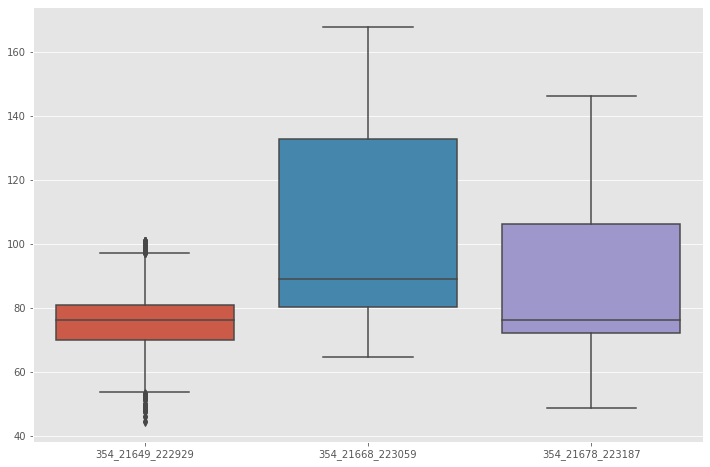

In [23]:
plt.rcParams["figure.figsize"] = (12,8)
fig3 = sns.boxplot(data=sel_points)

Ok, the first one (red) could be considered somehow "normal", but definitely not the other two. Let's inspect some line plots:

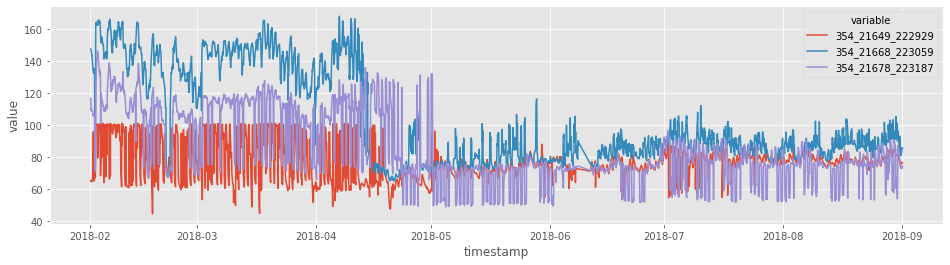

In [24]:
plt.rcParams["figure.figsize"] = (16,4)
fig4 = sns.lineplot(data=df1, x="timestamp", y="value", hue="variable")

We can see a pattern, but it's really noisy. Just for the following plot, we will resample our raw data daily:

In [25]:
# Resample
df2 = df_temp_raw[["timestamp"] + points].reset_index(drop=True).resample("24H", on="timestamp").mean().reset_index()

# and melt
df2 = df2.melt(id_vars=["timestamp"])

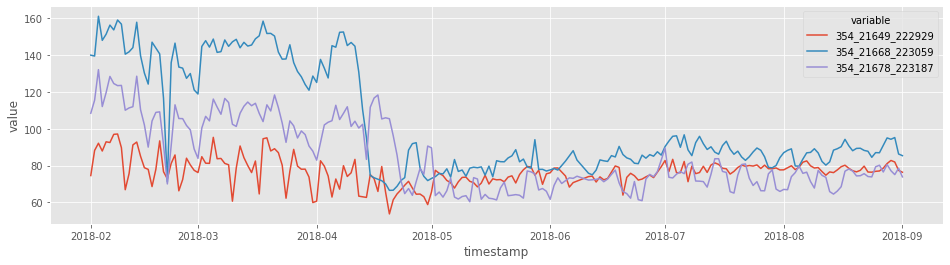

In [26]:
plt.rcParams["figure.figsize"] = (16,4)
fig5 = sns.lineplot(data=df2, x="timestamp", y="value", hue="variable")

Ok, looks like the weird behaviour is from February to May... that sounds seasonal. We can now a little more about these points querying the metadata from the API. Let's get the original points ids:

In [27]:
original_points_id = [p.split("_")[-1] for p in points]
original_points_id

['222929', '223059', '223187']

And get the information like we previously learned:

In [28]:
metadata = pd.DataFrame(client.get_points_by_ids(original_points_id))
metadata

,id,building_id,last_updated,first_updated,device,network_device,objectId,name,description,units,tagged_units,raw_unit_id,value,type,point_type_id,measurement_id,datasource_hash,topic,state_text,equip_id
0,222929,354,1.535774e+12,1.517461e+12,,None,,,Room S108 AC-3_CUH_Discharge Air Temp,F,None,2,76.1,Discharge Air Temperature,79,1,7b2920cc1a76aafa8c9366d2764309f1,nyserda+0000082140+cuh3-roomS108+Room S108 AC-...,None,21649
1,223059,354,1.535774e+12,1.517461e+12,,None,,,North Tech Wing Hall CUH_Discharge Air Temp,F,None,2,85.1,Discharge Air Temperature,79,1,8b412bd050d170550953ec27c956eed4,nyserda+0000082140+fcu-northTechWingHall+North...,None,21668
2,223187,354,1.535774e+12,1.517461e+12,,None,,,FCU-03 High School Main Lobby Vestibule_Discha...,F,None,2,74.1,Discharge Air Temperature,79,1,7b0117640e0be6a8feb116a569729029,nyserda+0000082140+fcu3-mainVestibule+FCU-03 H...,None,21678


We see that the zones served are a room, a wing hall and a high school lobby, no need for those high temperatures there. Buuuut... do you see it? two of the three points are not FCU, they are CUH! These are cabinet unit heaters! So it makes sense that in winter they are heating the zone.

So what happened here? maybe we retrieves the wrong data points, maybe they were wrongly identified. What we get from here is that from a simple heatmap was realy easy to identify the outliers among our sensors.

# Multivariate exploration

Another useful technique is to perform multivariate exploration: this is, getting two features (in this case, *discharge air temperature* and *command*) and plot them together to visualize how the relate and behave together.

We are going to select two sensors that we know we have the command data for. Here we need to find an equipment id in common (the point id will be different for each kind of sensor). We already looked for them behind the scen, but feel free to explore the data by yourself to find something else.

In [29]:
# this is just the list of points we have, we are looking for the equip id 17071 and 17080
temp_sel = df_temp_raw.columns[df_temp_raw.columns.str.contains("17071|17080")].to_list()
cmd_sel = df_cmd_raw.columns[df_cmd_raw.columns.str.contains("17071|17080")].to_list()

Let's create two simple data sets that will help us plot it really easily

In [30]:
df_17071 = pd.DataFrame({"discharge_air_temp_17071":df_temp_raw["101_17071_191409"], "command_17071":df_cmd_raw["101_17071_191417"] })
df_17080 = pd.DataFrame({"discharge_air_temp_17080":df_temp_raw["101_17080_191526"], "command_17080":df_cmd_raw["101_17080_191534"] })

Let's have the equipment information handy:

In [31]:
pd.DataFrame(client.get_equipment_by_ids([17080, 17071]))

,id,building_id,equip_id,suffix,equip_type_name,equip_type_id,equip_type_abbr,equip_type_tag,equip_subtype_name,equip_subtype_id,equip_subtype_tag,flow_order,floor_num_physical,floor_num_served,area_served_desc,equip_dis,parent_equip,child_equip,points,tags
0,17071,101,fcu-1-1,fcu-1-1,Fan Coil Unit,9,FCU,fcu,None,None,None,3,None,None,,FCU-1-1 Left 1st flr rear,[],[],[],[]
1,17080,101,fcu-5-6,fcu-5-6,Fan Coil Unit,9,FCU,fcu,None,None,None,3,None,None,,FCU-5-6 Front Right,[],[],[],[]


To visualize relation between features the more basic and powerful tool is a scatterplot. Here we will be using a [stripplot](https://seaborn.pydata.org/generated/seaborn.stripplot.html), which goes one step further: is a scatterplot, but the points are jittered around the axis to not overlap and visualize it better.

We want to see how the temperature values distribute based on the command value (0 or 1):

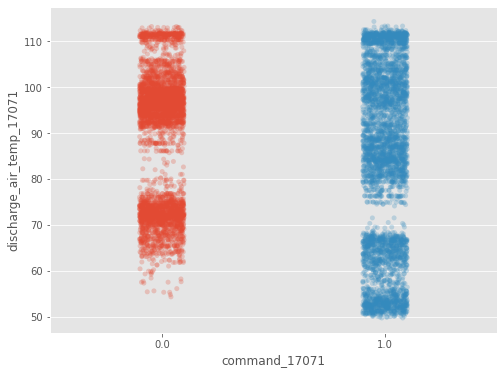

In [32]:
plt.rcParams["figure.figsize"] = (8,6)
fig6 = sns.stripplot(x="command_17071", y="discharge_air_temp_17071", data=df_17071, alpha=.25)

Ok, there is a pattern there. When command is 0 temperature usually gathers around 70ºF, 95ºF and 110ºF, and we have evident gaps below 60ºF, around 80-90ºF and around 105ºF. These gaps seems to be filled when commands is 1.

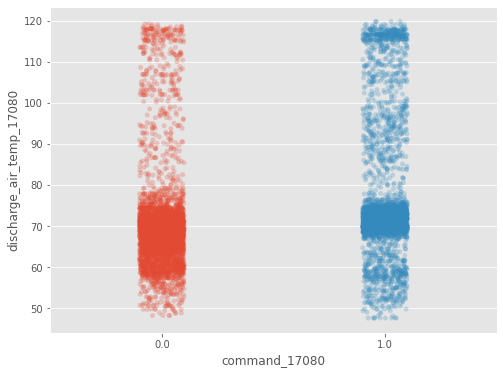

In [27]:
plt.rcParams["figure.figsize"] = (8,6)
fig7 = sns.stripplot(x="command_17080", y="discharge_air_temp_17080", data=df_17080, alpha=.25)

This plot is even more extreme. When command is 0 most of the values are around 55-65ºF, while when 1 the range is smaller: 65-75ºF.
